In [ ]:
!pip install datasets -q
!pip install transformers -q


!pip install peft -q
!pip install trl -q
!pip install bitsandbytes -q
!pip install accelerate -q

!pip install tensorboard -q
!pip install jsonlines -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:

import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer,SFTConfig


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "Qwen/Qwen2.5-3B-Instruct"


model = AutoModelForCausalLM.from_pretrained(model_name,torch_dtype=torch.float16).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name,torch_dtype=torch.float16)
print(model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-35): 36 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=256, bias=True)
          (v_proj): Linear(in_features=2048, out_features=256, bias=True)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=2048, out_features=11008, bias=False)
          (up_proj): Linear(in_features=2048, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((2048,), eps=1e-06)
    (rotary_emb):

In [ ]:
input_text = "What should I do on a trip to Europe?"

input_ids = tokenizer(input_text, return_tensors="pt").to(device)
outputs = model.generate(**input_ids, max_length=128)
print(tokenizer.decode(outputs[0]))

In [ ]:
from datasets import load_dataset, Dataset

dataset = load_dataset("json", data_files="input.json")

dataset = dataset["train"].rename_columns({"question": "Instruction", "answer": "Response"})


dataset_gpu = Dataset.from_list([{k: v for k, v in example.items()} for example in dataset])

print(f"Dataset loaded on {device}")
print(dataset_gpu[0])


Dataset loaded on cuda
{'Instruction': 'What is the main goal of DeepSeek-R1-Zero?', 'Response': 'The main goal of DeepSeek-R1-Zero is to explore the potential of LLMs to develop reasoning capabilities without any supervised data, focusing on their self-evolution through a pure reinforcement learning process.'}


In [ ]:
model_name = "Qwen/Qwen2.5-3B-Instruct"
new_model = "Qwen/Qwen2.5-3B-Instruct-ft"

################################################################################
# LoRA parameters
################################################################################

lora_r = 4

lora_alpha = 16

lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

use_4bit = True

bnb_4bit_compute_dtype = "float16"

bnb_4bit_quant_type = "nf4"

use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

output_dir = "/content/drive/MyDrive/results"

num_train_epochs = 10

fp16 = False
bf16 = False

per_device_train_batch_size = 4

per_device_eval_batch_size = 4

gradient_accumulation_steps = 1

gradient_checkpointing = True

max_grad_norm = 0.3

learning_rate = 2e-4

weight_decay = 0.001

optim = "paged_adamw_32bit"

lr_scheduler_type = "constant"

max_steps = -1

warmup_ratio = 0.03


group_by_length = True

save_steps = 25

logging_steps = 25

################################################################################
# SFT parameters
################################################################################

max_seq_length = 40

packing = True

device_map="auto"

In [ ]:
from transformers import BitsAndBytesConfig
# Load QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit, # Activates 4-bit precision loading
    bnb_4bit_quant_type=bnb_4bit_quant_type, # nf4
    bnb_4bit_compute_dtype=compute_dtype, # float16
    bnb_4bit_use_double_quant=use_nested_quant, # False
)

In [ ]:
# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("Setting BF16 to True")
        bf16 = True
    else:
        bf16 = False

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name,trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj", "up_proj"]
)

In [ ]:
# Set training parameters
training_arguments = SFTConfig(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard",
    dataset_text_field="Instruction",
     max_seq_length=max_seq_length,
        packing=packing,
)
training_arguments

SFTConfig(output_dir='/content/drive/MyDrive/results', overwrite_output_dir=False, do_train=False, do_eval=False, do_predict=False, eval_strategy=<IntervalStrategy.NO: 'no'>, prediction_loss_only=False, per_device_train_batch_size=4, per_device_eval_batch_size=8, per_gpu_train_batch_size=None, per_gpu_eval_batch_size=None, gradient_accumulation_steps=1, eval_accumulation_steps=None, eval_delay=0, torch_empty_cache_steps=None, learning_rate=0.0002, weight_decay=0.001, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=0.3, num_train_epochs=10, max_steps=-1, lr_scheduler_type=<SchedulerType.CONSTANT: 'constant'>, lr_scheduler_kwargs={}, warmup_ratio=0.03, warmup_steps=0, log_level='passive', log_level_replica='warning', log_on_each_node=True, logging_dir='/content/drive/MyDrive/results/runs/Mar08_13-55-08_1938e7a22b19', logging_strategy=<IntervalStrategy.STEPS: 'steps'>, logging_first_step=False, logging_steps=25, logging_nan_inf_filter=True, save_strategy=<SaveStrategy.

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    tokenizer=tokenizer,
    args=training_arguments
)

<ipython-input-30-04a5082c599d>:1: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


In [ ]:
 # Change this to your preferred location
output_dir = "/content/drive/MyDrive/results"
# Train model
trainer.train()

# Save the trained model to the specified directory
trainer.model.save_pretrained(output_dir)

Step,Training Loss
25,1.309100
50,0.545300
75,0.259500
100,0.135800
125,0.081200
150,0.084200


# load saved model

In [ ]:
output_dir = "/content/drive/MyDrive/results/checkpoint-150"
model = PeftModel.from_pretrained(model, output_dir)
tokenizer = AutoTokenizer.from_pretrained(output_dir)

print("Fine-tuned model reloaded successfully!")

Fine-tuned model reloaded successfully!


In [ ]:
merge_model_save_path = "/content/drive/MyDrive/intellihack_task_03/merged_model"

In [ ]:
tokenizer.save_pretrained(merge_model_save_path)

('/content/drive/MyDrive/intellihack_task_03/merged_model/tokenizer_config.json',
 '/content/drive/MyDrive/intellihack_task_03/merged_model/special_tokens_map.json',
 '/content/drive/MyDrive/intellihack_task_03/merged_model/vocab.json',
 '/content/drive/MyDrive/intellihack_task_03/merged_model/merges.txt',
 '/content/drive/MyDrive/intellihack_task_03/merged_model/added_tokens.json',
 '/content/drive/MyDrive/intellihack_task_03/merged_model/tokenizer.json')

In [ ]:
merge_model = model.merge_and_unload()
merge_model.save_pretrained(merge_model_save_path)

## Download lama.cpp

In [ ]:
!git clone https://github.com/ggerganov/llama.cpp

Cloning into 'llama.cpp'...
remote: Enumerating objects: 45728, done.
remote: Counting objects: 100% (336/336), done.
remote: Compressing objects: 100% (248/248), done.
remote: Total 45728 (delta 224), reused 88 (delta 88), pack-reused 45392 (from 3)
Receiving objects: 100% (45728/45728), 96.75 MiB | 24.08 MiB/s, done.
Resolving deltas: 100% (32957/32957), done.


In [ ]:
!pip install -r llama.cpp/requirements.txt


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu, https://download.pytorch.org/whl/cpu, https://download.pytorch.org/whl/cpu, https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/4

In [ ]:
%cd llama.cpp
!cmake -B build

/content/llama.cpp
-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found Git: /usr/bin/git (found version "2.34.1")
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Success
-- Found Threads: TRUE
-- Warning: ccache not found - consider installing it for faster compilation or disable this warning with GGML_CCACHE=OFF
-- CMAKE_SYSTEM_PROCESSOR: x86_64
-- Including CPU backend
-- Found OpenMP_C: -fopenmp (found version "4.5")
-- Found OpenMP_CXX: -fopenmp (found version "4.5")
-- Found OpenMP: TRUE 

In [ ]:
%cd /content/llama.cpp/build
!make -j$(nproc)

/content/llama.cpp/build
[  0%] Building C object ggml/src/CMakeFiles/ggml-base.dir/ggml.c.o
[  0%] Generating build details from Git
-- Found Git: /usr/bin/git (found version "2.34.1")
[  0%] Building CXX object common/CMakeFiles/build_info.dir/build-info.cpp.o
[  0%] Built target build_info
[  1%] Building C object examples/gguf-hash/CMakeFiles/sha256.dir/deps/sha256/sha256.c.o
[  1%] Built target sha256
[  2%] Building C object examples/gguf-hash/CMakeFiles/xxhash.dir/deps/xxhash/xxhash.c.o
[  2%] Built target xxhash
[  2%] Building C object examples/gguf-hash/CMakeFiles/sha1.dir/deps/sha1/sha1.c.o
[  2%] Built target sha1
[  3%] Building C object ggml/src/CMakeFiles/ggml-base.dir/ggml-alloc.c.o
[  3%] Building CXX object ggml/src/CMakeFiles/ggml-base.dir/ggml-backend.cpp.o
[  4%] Building CXX object ggml/src/CMakeFiles/ggml-base.dir/ggml-opt.cpp.o
[  4%] Building CXX object ggml/src/CMakeFiles/ggml-base.dir/ggml-threading.cpp.o
[  5%] Building C object ggml/src/CMakeFiles/ggml-base

In [ ]:
!ls -l /content/llama.cpp/build/bin


total 69248
-rwxr-xr-x 1 root root  653704 Mar  9 09:46 libggml-base.so
-rwxr-xr-x 1 root root  522792 Mar  9 09:46 libggml-cpu.so
-rwxr-xr-x 1 root root   59192 Mar  9 09:46 libggml.so
-rwxr-xr-x 1 root root 1862168 Mar  9 09:48 libllama.so
-rwxr-xr-x 1 root root  524040 Mar  9 09:53 libllava_shared.so
-rwxr-xr-x 1 root root 1880912 Mar  9 09:50 llama-batched
-rwxr-xr-x 1 root root 1880984 Mar  9 09:50 llama-batched-bench
-rwxr-xr-x 1 root root  514224 Mar  9 09:51 llama-bench
-rwxr-xr-x 1 root root 1916712 Mar  9 09:51 llama-cli
-rwxr-xr-x 1 root root  381112 Mar  9 09:52 llama-convert-llama2c-to-ggml
-rwxr-xr-x 1 root root 1906224 Mar  9 09:52 llama-cvector-generator
-rwxr-xr-x 1 root root 1885360 Mar  9 09:51 llama-embedding
-rwxr-xr-x 1 root root 1881288 Mar  9 09:51 llama-eval-callback
-rwxr-xr-x 1 root root 1915088 Mar  9 09:53 llama-export-lora
-rwxr-xr-x 1 root root   26856 Mar  9 09:51 llama-gbnf-validator
-rwxr-xr-x 1 root root 1877152 Mar  9 09:52 llama-gen-docs
-rwxr-xr-x 

In [ ]:
!python3 /content/llama.cpp/convert_hf_to_gguf.py /content/drive/MyDrive/intellihack_task_03/merged_model --outfile /content/output_f16.gguf

INFO:hf-to-gguf:Loading model: merged_model
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:gguf: loading model weight map from 'model.safetensors.index.json'
INFO:hf-to-gguf:gguf: loading model part 'model-00001-of-00002.safetensors'
INFO:hf-to-gguf:token_embd.weight,         torch.float16 --> F16, shape = {2048, 151936}
INFO:hf-to-gguf:blk.0.attn_norm.weight,    torch.float16 --> F32, shape = {2048}
INFO:hf-to-gguf:blk.0.ffn_down.weight,     torch.float16 --> F16, shape = {11008, 2048}
INFO:hf-to-gguf:blk.0.ffn_gate.weight,     torch.float16 --> F16, shape = {2048, 11008}
INFO:hf-to-gguf:blk.0.ffn_up.weight,       torch.float16 --> F16, shape = {2048, 11008}
INFO:hf-to-gguf:blk.0.ffn_norm.weight,     torch.float16 --> F32, shape = {2048}
INFO:hf-to-gguf:blk.0.attn_k.bias,         torch.float16 --> F32, shape = {256}
INFO:hf-to-gguf:blk.0.attn_k.weight,       torch.float16 --> F16, shape = {2048, 256}
INFO:hf-to-g

#screen shot

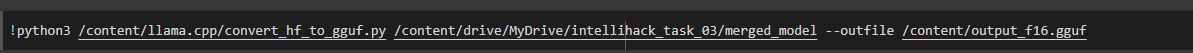


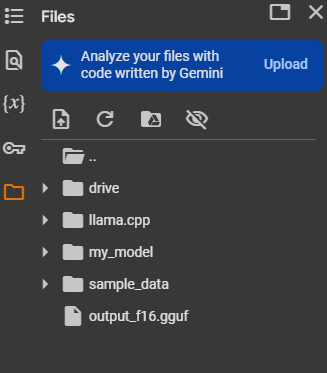

In [ ]:
!chmod +r /content/output_f16.gguf

In [ ]:
! /content/llama.cpp/build/bin/llama-quantize /content/output_f16.gguf /content/drive/MyDrive/intellihack_task_03/model_f4.gguf Q4_K_M

main: build = 4857 (0fd7ca7a)
main: built with cc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0 for x86_64-linux-gnu
main: quantizing '/content/output_f16.gguf' to '/content/drive/MyDrive/intellihack_task_03/model_f4.gguf' as Q4_K_M
llama_model_loader: loaded meta data with 27 key-value pairs and 434 tensors from /content/output_f16.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = qwen2
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Qwen2.5 3B Instruct
llama_model_loader: - kv   3:                       general.organization str              = Qwen
llama_model_loader: - kv   4:                           general.finetune str              = Instruct
llama_model_loader: - kv   5:        

#screen shot

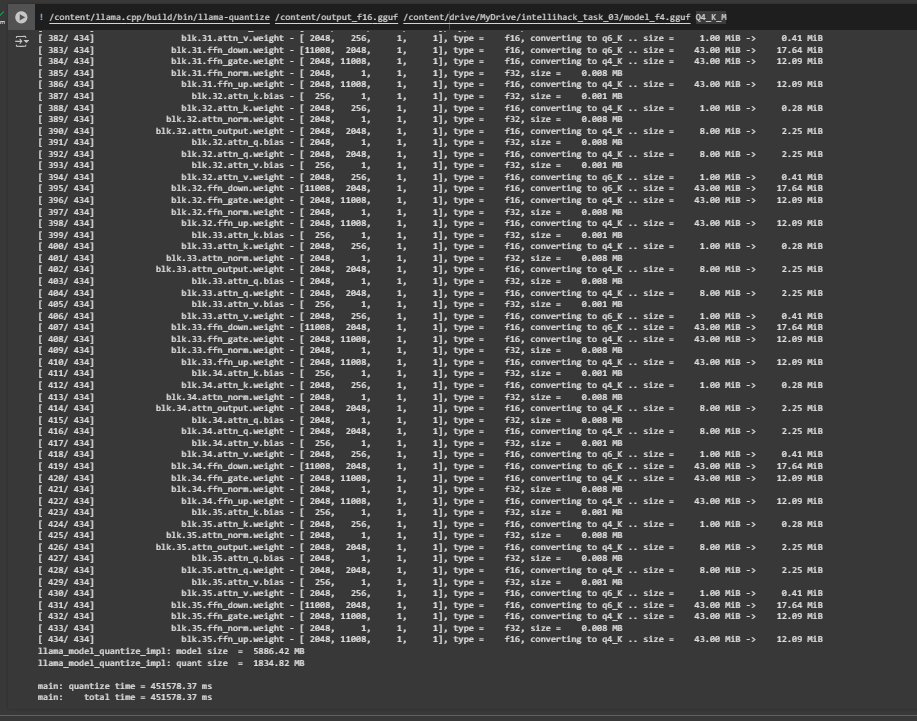

In [ ]:
!pip install ctransformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 20.6 MB/s eta 0:00:00


In [ ]:
model_path = "/content/drive/MyDrive/intellihack_task_03/model_f4.gguf"

In [ ]:
!pip install llama-cpp-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.2 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.3.7-cp311-cp311-linux_x86_64.whl size=4552845 sha256=0f049da442f4d20a6fd21193386a124b216a41ac39d88fe9c7340367bdd05b87
  Stored in directory: /root/.cache/pip/wheels/eb/82/79/ac77fcd49324b75ae6aa18e63a87cf9da4371a57e2cdc8dc03
Successfully built llama-cpp-python


In [ ]:
from llama_cpp import Llama

# Load the GGUF model
llm = Llama(model_path=model_path)

llama_model_loader: loaded meta data with 27 key-value pairs and 434 tensors from /content/drive/MyDrive/intellihack_task_03/model_f4.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = qwen2
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Qwen2.5 3B Instruct
llama_model_loader: - kv   3:                       general.organization str              = Qwen
llama_model_loader: - kv   4:                           general.finetune str              = Instruct
llama_model_loader: - kv   5:                           general.basename str              = Qwen2.5
llama_model_loader: - kv   6:                         general.size_label str              = 3B
llama_model_loader: - kv   7:      

In [ ]:
question = "what is the third planet in solr system?"


prompt = f"""
You are an AI assistant. Answer the given question concisely but provide an explanation **only if it is directly related to the topic**.

Here are some examples:

Q: What is the capital of France?
A: Paris. It is the largest city in France and an important cultural and economic hub.

Q: Who wrote '1984'?
A: George Orwell. The novel is a dystopian classic that explores themes of surveillance and totalitarianism.

Q: What is 5 + 7?
A: 12. Addition is a fundamental arithmetic operation.

Now, answer the following:

Q: {question}
A:"""


output = llm(
    prompt,
    temperature=0.7,  # Controls randomness
    top_p=0.9  # Nucleus sampling
)

print(output["choices"][0]["text"])


llama_perf_context_print:        load time =    2296.74 ms
llama_perf_context_print: prompt eval time =   36095.06 ms /   145 tokens (  248.93 ms per token,     4.02 tokens per second)
llama_perf_context_print:        eval time =    4869.87 ms /    15 runs   (  324.66 ms per token,     3.08 tokens per second)
llama_perf_context_print:       total time =   40993.37 ms /   160 tokens


 The third planet in the solar system is Mars. It is known for its redd


#screen shot

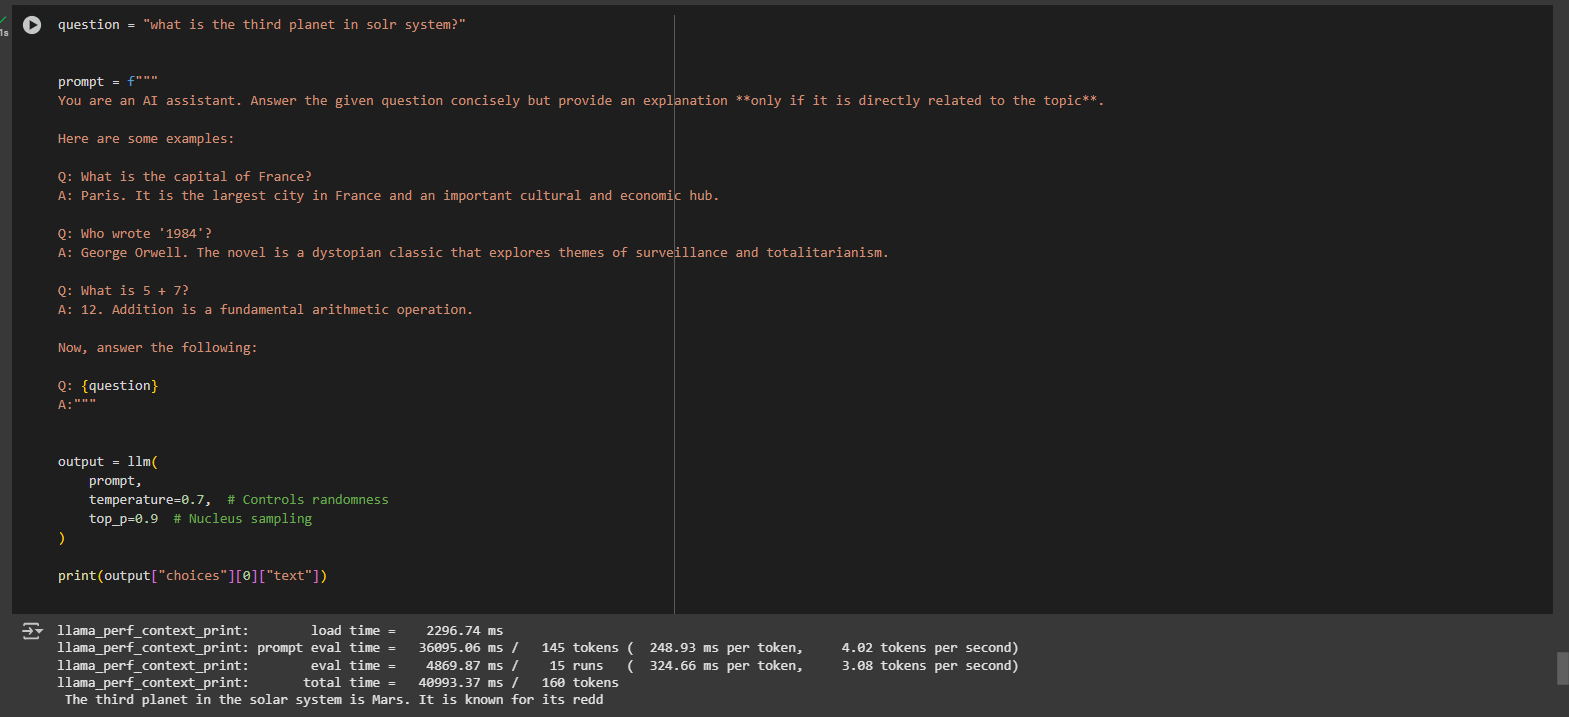

#Implementing RAG

In [ ]:
!pip install langchain-community -q
!pip install pypdf -q
!pip install unstructured -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.8/166.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 8.7 MB/s eta 0:00:00


In [ ]:
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader, TextLoader

path = "/content/drive/MyDrive/intellihack_task_03/q3_dataset"


md_loader = DirectoryLoader(path, glob="**/*.md", loader_cls=TextLoader)


pdf_loader = DirectoryLoader(path, glob="**/*.pdf", loader_cls=PyPDFLoader)


RAW_KNOWLEDGE_BASE = md_loader.load() + pdf_loader.load()


print(f"Loaded {len(RAW_KNOWLEDGE_BASE)} documents")

Loaded 27 documents


In [ ]:
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer
from typing import List,Optional
from langchain.docstore.document import Document as LangchainDocument

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


In [ ]:
docs_processed = split_documents(
    256,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)


In [ ]:
!pip install faiss-cpu -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 22.5 MB/s eta 0:00:00


In [ ]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": 'cpu'},
    encode_kwargs={"normalize_embeddings": True},
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

In [ ]:
knowledge_base_path = "/content/drive/MyDrive/intellihack_task_03/knowledge_base"

In [ ]:
KNOWLEDGE_VECTOR_DATABASE.save_local(knowledge_base_path)

NEW_KNOWLEDGE_VECTOR_DATABASE = FAISS.load_local(knowledge_base_path, embedding_model,allow_dangerous_deserialization=True)

user_query = "what is deep-seek?"

docs = NEW_KNOWLEDGE_VECTOR_DATABASE.similarity_search(user_query,k=5)


In [ ]:
docs

[Document(id='e2f705b6-2253-462d-9cac-0cedbf0a8789', metadata={'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-01-23T01:45:31+00:00', 'author': '', 'keywords': '', 'moddate': '2025-01-23T01:45:31+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'subject': '', 'title': '', 'trapped': '/False', 'source': '/content/drive/MyDrive/intellihack_task_03/q3_dataset/2501.12948v1.pdf', 'total_pages': 22, 'page': 7, 'page_label': '8', 'start_index': 0}, page_content='Figure 3 |The average response length of DeepSeek-R1-Zero on the training set during the RL\nprocess. DeepSeek-R1-Zero naturally learns to solve reasoning tasks with more thinking time.\nment throughout the training process. This improvement is not the result of external adjustments\nbut rather an intrinsic development within the model. DeepSeek-R1-Zero naturally acquires the\nability to solve increasingly complex reasoning tasks 

#RAG pipeline

In [ ]:
from llama_cpp import Llama

def get_ai_answer(question, llm, knowledge_db):
    """
    Retrieves relevant documents from a knowledge database and generates an AI research-based answer.

    Parameters:
        - question (str): The user's question.
        - llm (Llama): The loaded Llama model.
        - knowledge_db: The vector database for similarity search.
        - temperature (float): Controls randomness in response.
        - top_p (float): Nucleus sampling threshold.

    Returns:
        - str: The AI-generated answer.
    """

    # Retrieve relevant documents (e.g., top 5 matches)
    docs = knowledge_db.similarity_search(question, k=1)  # Retrieve 5 relevant docs

    # If no relevant documents are found, return a fallback response
    if not docs:
        return "I don't have enough information to answer that."

    # Merge all retrieved documents into a single string
    # Extract text from LangChain Document objects
    merged_context = "\n\n".join([doc.page_content for doc in docs])


    # Create a prompt using the merged context
    prompt = f"""
    You are an AI assistant specializing in AI research. Your task is to answer questions **based only on the provided context**.
    If the context does not contain relevant information, say: "I don't have enough information to answer that."

    Your answers should be include explanations **only if they are directly related to the question**.

    ### **Context:**
    {merged_context}

    ### **Examples:**

    Q: What is reinforcement learning?
    A: Reinforcement learning (RL) is a machine learning paradigm where an agent learns by interacting with an environment to maximize cumulative rewards. It is widely used in robotics, game playing, and autonomous systems.


    Q: {question}
    A:
    """

    # Generate answer using Llama model
    output = llm(prompt)

    return output["choices"][0]["text"].strip()


In [ ]:
question = "what is deep-seek"
answer = get_ai_answer(question, llm, NEW_KNOWLEDGE_VECTOR_DATABASE)
print(answer)

Llama.generate: 55 prefix-match hit, remaining 150 prompt tokens to eval
llama_perf_context_print:        load time =    2296.74 ms
llama_perf_context_print: prompt eval time =   30466.30 ms /   150 tokens (  203.11 ms per token,     4.92 tokens per second)
llama_perf_context_print:        eval time =    5001.32 ms /    15 runs   (  333.42 ms per token,     3.00 tokens per second)
llama_perf_context_print:       total time =   35496.37 ms /   165 tokens


DeepSeek is a framework for deep reinforcement learning. It enables the training of deep


#screen shot

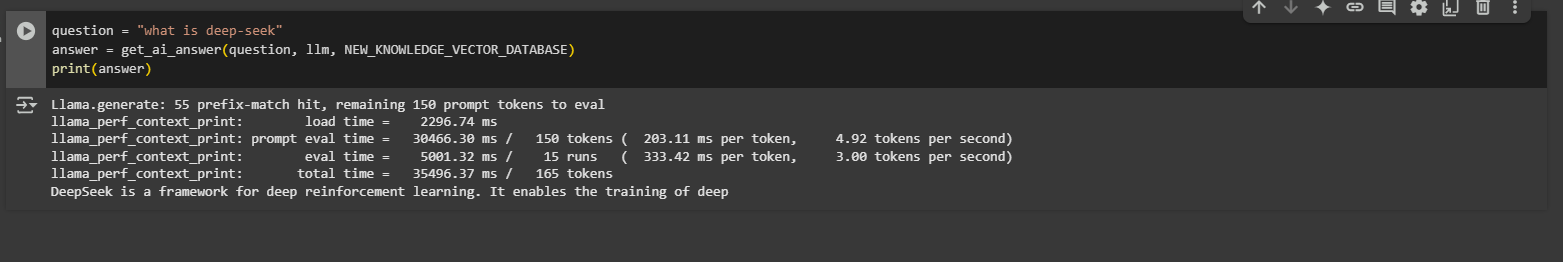